# Recomendações - Cálculo de Economia - Economiza+ MVP

**Sprint 2 - Dia 9**  
**Objetivo:** Calcular economia potencial por usuário e validar H1

**Hipótese H1:** Recomendações geram economia de 15-20%

**Entregáveis:**
- `economia_projetada.csv` com economia por usuário
- Validação da hipótese H1
- Visualizações de economia por cluster

## 1. Setup e Carregamento de Dados

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
np.random.seed(42)

In [2]:
# Carregar dados
usuarios_clustered = pd.read_csv('../data/processed/usuarios_clustered.csv')
transacoes = pd.read_csv('../data/raw/transacoes.csv')

# Carregar regras de recomendação
with open('../models/recomendacoes_regras.json', 'r', encoding='utf-8') as f:
    regras_json = json.load(f)

REGRAS_RECOMENDACAO = {int(k): v for k, v in regras_json['clusters'].items()}

print(f"Usuários: {len(usuarios_clustered)}")
print(f"Transações: {len(transacoes)}")
print(f"Regras carregadas: {regras_json['total_regras']}")

Usuários: 500
Transações: 194231
Regras carregadas: 8


In [3]:
# Nomes dos clusters
NOMES_CLUSTERS = {
    0: 'Endividados Severos',
    1: 'Em Alerta',
    2: 'Endividados Moderados',
    3: 'Poupadores'
}

# Filtrar apenas gastos
gastos = transacoes[transacoes['categoria'] != 'Renda'].copy()
print(f"Transações de gasto: {len(gastos)}")

Transações de gasto: 191231


## 2. Funções de Cálculo de Economia

In [4]:
def calcular_gasto_medio_categoria(user_id, categoria, transacoes_df):
    """
    Calcula o gasto médio mensal de um usuário em uma categoria.
    """
    user_transacoes = transacoes_df[
        (transacoes_df['user_id'] == user_id) & 
        (transacoes_df['categoria'] == categoria)
    ]
    
    if len(user_transacoes) == 0:
        return 0.0
    
    gasto_mensal = user_transacoes.groupby('mes')['valor'].sum()
    return gasto_mensal.mean()


def calcular_economia_usuario(user_id, cluster, transacoes_df, regras):
    """
    Calcula economia detalhada para um usuário.
    
    Retorna dict com:
    - economia por recomendação
    - economia total
    - percentual de economia sobre renda
    """
    cluster_regras = regras[cluster]
    
    resultado = {
        'user_id': user_id,
        'cluster': cluster,
        'cluster_nome': cluster_regras['nome']
    }
    
    economia_total = 0
    
    for i, regra in enumerate(cluster_regras['regras'], 1):
        gasto_atual = calcular_gasto_medio_categoria(
            user_id, regra['categoria'], transacoes_df
        )
        economia = gasto_atual * regra['percentual']
        
        resultado[f'categoria_{i}'] = regra['categoria']
        resultado[f'gasto_atual_{i}'] = round(gasto_atual, 2)
        resultado[f'economia_{i}'] = round(economia, 2)
        resultado[f'recomendacao_{i}'] = regra['titulo']
        
        economia_total += economia
    
    resultado['economia_total'] = round(economia_total, 2)
    
    return resultado

print("Funções de cálculo definidas!")

Funções de cálculo definidas!


## 3. Calcular Economia para Todos os Usuários

In [5]:
# Calcular economia para cada usuário
resultados = []

for _, row in usuarios_clustered.iterrows():
    user_id = row['user_id']
    cluster = row['cluster']
    
    economia = calcular_economia_usuario(user_id, cluster, gastos, REGRAS_RECOMENDACAO)
    
    # Adicionar dados do usuário
    economia['media_renda'] = row['media_renda']
    economia['media_gasto'] = row['media_gasto']
    economia['taxa_poupanca_atual'] = row['taxa_poupanca']
    
    resultados.append(economia)

# Criar DataFrame
economia_df = pd.DataFrame(resultados)

print(f"Economia calculada para {len(economia_df)} usuários")
economia_df.head()

Economia calculada para 500 usuários


,user_id,cluster,cluster_nome,categoria_1,gasto_atual_1,economia_1,recomendacao_1,categoria_2,gasto_atual_2,economia_2,recomendacao_2,economia_total,media_renda,media_gasto,taxa_poupanca_atual
0,user_0001,3,Poupadores,Transporte,486.08,72.91,Otimizar gastos com transporte,Telecomunicacoes,103.30,20.66,Revisar planos e assinaturas,93.57,11614.322645,3834.969272,0.669807
1,user_0002,0,Endividados Severos,Alimentacao_Fora,737.54,516.28,Cortar refeições fora de casa,Vestuario,362.20,325.98,Suspender compras de vestuário,842.26,3615.436000,7084.610157,-0.959545
2,user_0003,3,Poupadores,Transporte,491.59,73.74,Otimizar gastos com transporte,Telecomunicacoes,102.18,20.44,Revisar planos e assinaturas,94.17,6055.769376,3473.659979,0.426388
3,user_0004,1,Em Alerta,Alimentacao_Fora,342.10,136.84,Reduzir refeições fora de casa,Lazer,89.54,31.34,Estabelecer teto para lazer,168.18,2765.230000,3815.743179,-0.379901
4,user_0005,3,Poupadores,Transporte,771.63,115.74,Otimizar gastos com transporte,Telecomunicacoes,149.63,29.93,Revisar planos e assinaturas,145.67,6475.678303,6118.832497,0.055106


In [6]:
# Calcular percentual de economia sobre renda e gasto
economia_df['pct_economia_renda'] = (economia_df['economia_total'] / economia_df['media_renda']) * 100
economia_df['pct_economia_gasto'] = (economia_df['economia_total'] / economia_df['media_gasto']) * 100

# Calcular nova taxa de poupança projetada
economia_df['gasto_projetado'] = economia_df['media_gasto'] - economia_df['economia_total']
economia_df['taxa_poupanca_projetada'] = (
    (economia_df['media_renda'] - economia_df['gasto_projetado']) / economia_df['media_renda']
)

# Melhoria na taxa de poupança
economia_df['melhoria_poupanca'] = (
    economia_df['taxa_poupanca_projetada'] - economia_df['taxa_poupanca_atual']
) * 100  # em pontos percentuais

print("Métricas calculadas!")
economia_df[['user_id', 'cluster', 'economia_total', 'pct_economia_renda', 'pct_economia_gasto']].head(10)

Métricas calculadas!


,user_id,cluster,economia_total,pct_economia_renda,pct_economia_gasto
0,user_0001,3,93.57,0.805643,2.439915
1,user_0002,0,842.26,23.296222,11.888586
2,user_0003,3,94.17,1.555046,2.710973
3,user_0004,1,168.18,6.081953,4.407529
4,user_0005,3,145.67,2.249494,2.380683
5,user_0006,1,101.40,4.654575,4.212443
6,user_0007,1,208.09,4.577748,5.378462
7,user_0008,2,496.77,12.347290,8.212247
8,user_0009,1,102.70,4.928733,4.512174
9,user_0010,1,228.33,7.341149,5.053601


## 4. Validação da Hipótese H1

**H1:** Recomendações geram economia de 15-20% sobre a renda

In [7]:
# Estatísticas gerais
print("="*70)
print("VALIDAÇÃO DA HIPÓTESE H1")
print("Target: Economia de 15-20% sobre a renda")
print("="*70)

# Economia média geral
economia_media_geral = economia_df['pct_economia_renda'].mean()
economia_mediana_geral = economia_df['pct_economia_renda'].median()

print(f"\n>>> ECONOMIA MÉDIA GERAL: {economia_media_geral:.2f}% da renda")
print(f">>> ECONOMIA MEDIANA GERAL: {economia_mediana_geral:.2f}% da renda")

# Verificar se atinge o target
TARGET_MIN = 15
TARGET_MAX = 20

if TARGET_MIN <= economia_media_geral <= TARGET_MAX:
    print(f"\n>>> STATUS H1: VALIDADA (dentro do range {TARGET_MIN}-{TARGET_MAX}%)")
    h1_status = 'VALIDADA'
elif economia_media_geral > TARGET_MAX:
    print(f"\n>>> STATUS H1: SUPERADA (acima de {TARGET_MAX}%)")
    h1_status = 'SUPERADA'
else:
    print(f"\n>>> STATUS H1: NÃO ATINGIDA (abaixo de {TARGET_MIN}%)")
    h1_status = 'NÃO ATINGIDA'

VALIDAÇÃO DA HIPÓTESE H1
Target: Economia de 15-20% sobre a renda

>>> ECONOMIA MÉDIA GERAL: 8.11% da renda
>>> ECONOMIA MEDIANA GERAL: 6.72% da renda

>>> STATUS H1: NÃO ATINGIDA (abaixo de 15%)


In [8]:
# Economia por cluster
print("\n" + "="*70)
print("ECONOMIA POR CLUSTER")
print("="*70)

economia_por_cluster = economia_df.groupby('cluster').agg({
    'economia_total': ['mean', 'sum', 'std'],
    'pct_economia_renda': ['mean', 'median', 'std'],
    'pct_economia_gasto': ['mean', 'median'],
    'user_id': 'count'
}).round(2)

economia_por_cluster.columns = [
    'economia_media_R$', 'economia_total_R$', 'economia_std_R$',
    'pct_renda_media', 'pct_renda_mediana', 'pct_renda_std',
    'pct_gasto_media', 'pct_gasto_mediana',
    'num_usuarios'
]

economia_por_cluster.index = [NOMES_CLUSTERS[i] for i in economia_por_cluster.index]

print("\n")
print(economia_por_cluster.to_string())


ECONOMIA POR CLUSTER


                       economia_media_R$  economia_total_R$  economia_std_R$  pct_renda_media  pct_renda_mediana  pct_renda_std  pct_gasto_media  pct_gasto_mediana  num_usuarios
Endividados Severos               698.53           41213.43           210.33            19.22              18.41           5.53             9.51               9.00            59
Em Alerta                         162.59           31866.98            50.82             5.37               5.16           1.59             4.68               4.49           196
Endividados Moderados             320.13           53461.72           100.65            10.38               9.64           3.13             6.51               6.18           167
Poupadores                        120.90            9430.04            38.02             1.72               1.64           0.51             2.30               2.29            78


In [9]:
# Tabela resumida para validação H1
print("\n" + "="*70)
print("RESUMO: % ECONOMIA SOBRE RENDA POR CLUSTER")
print("="*70)

for cluster_id in range(4):
    cluster_data = economia_df[economia_df['cluster'] == cluster_id]
    pct_medio = cluster_data['pct_economia_renda'].mean()
    num_usuarios = len(cluster_data)
    
    # Verificar se atinge target
    if TARGET_MIN <= pct_medio <= TARGET_MAX:
        status = "DENTRO DO TARGET"
    elif pct_medio > TARGET_MAX:
        status = "ACIMA DO TARGET"
    else:
        status = "ABAIXO DO TARGET"
    
    print(f"\nCluster {cluster_id} - {NOMES_CLUSTERS[cluster_id]}:")
    print(f"  Usuários: {num_usuarios}")
    print(f"  Economia média: {pct_medio:.2f}% da renda")
    print(f"  Status: {status}")


RESUMO: % ECONOMIA SOBRE RENDA POR CLUSTER

Cluster 0 - Endividados Severos:
  Usuários: 59
  Economia média: 19.22% da renda
  Status: DENTRO DO TARGET

Cluster 1 - Em Alerta:
  Usuários: 196
  Economia média: 5.37% da renda
  Status: ABAIXO DO TARGET

Cluster 2 - Endividados Moderados:
  Usuários: 167
  Economia média: 10.38% da renda
  Status: ABAIXO DO TARGET

Cluster 3 - Poupadores:
  Usuários: 78
  Economia média: 1.72% da renda
  Status: ABAIXO DO TARGET


## 5. Visualizações

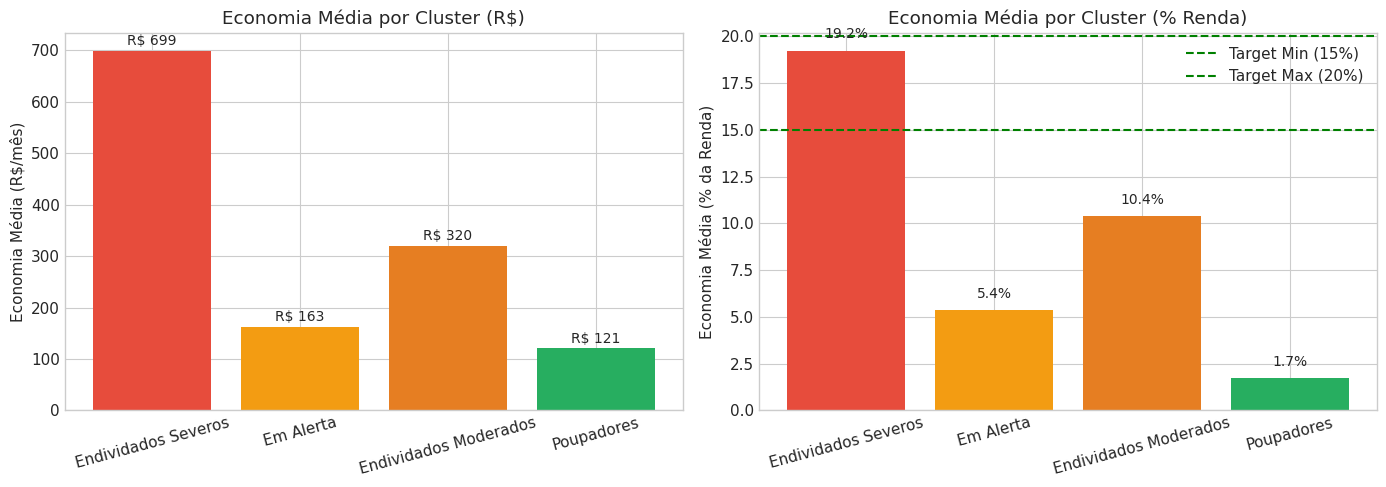

Gráfico salvo: outputs/economia_por_cluster.png


In [10]:
# Criar diretório de outputs se não existir
os.makedirs('../outputs', exist_ok=True)

# Gráfico 1: Economia média por cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1a. Economia em R$
economia_media_cluster = economia_df.groupby('cluster')['economia_total'].mean()
cores = ['#e74c3c', '#f39c12', '#e67e22', '#27ae60']

bars1 = axes[0].bar(
    [NOMES_CLUSTERS[i] for i in economia_media_cluster.index],
    economia_media_cluster.values,
    color=cores
)
axes[0].set_ylabel('Economia Média (R$/mês)')
axes[0].set_title('Economia Média por Cluster (R$)')
axes[0].tick_params(axis='x', rotation=15)

# Adicionar valores nas barras
for bar, val in zip(bars1, economia_media_cluster.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'R$ {val:.0f}', ha='center', va='bottom', fontsize=10)

# 1b. Economia em % da renda
pct_economia_cluster = economia_df.groupby('cluster')['pct_economia_renda'].mean()

bars2 = axes[1].bar(
    [NOMES_CLUSTERS[i] for i in pct_economia_cluster.index],
    pct_economia_cluster.values,
    color=cores
)
axes[1].set_ylabel('Economia Média (% da Renda)')
axes[1].set_title('Economia Média por Cluster (% Renda)')
axes[1].tick_params(axis='x', rotation=15)

# Linha do target
axes[1].axhline(y=TARGET_MIN, color='green', linestyle='--', label=f'Target Min ({TARGET_MIN}%)')
axes[1].axhline(y=TARGET_MAX, color='green', linestyle='--', label=f'Target Max ({TARGET_MAX}%)')
axes[1].legend()

# Adicionar valores nas barras
for bar, val in zip(bars2, pct_economia_cluster.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/economia_por_cluster.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/economia_por_cluster.png")

/tmp/ipykernel_13656/1822279267.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


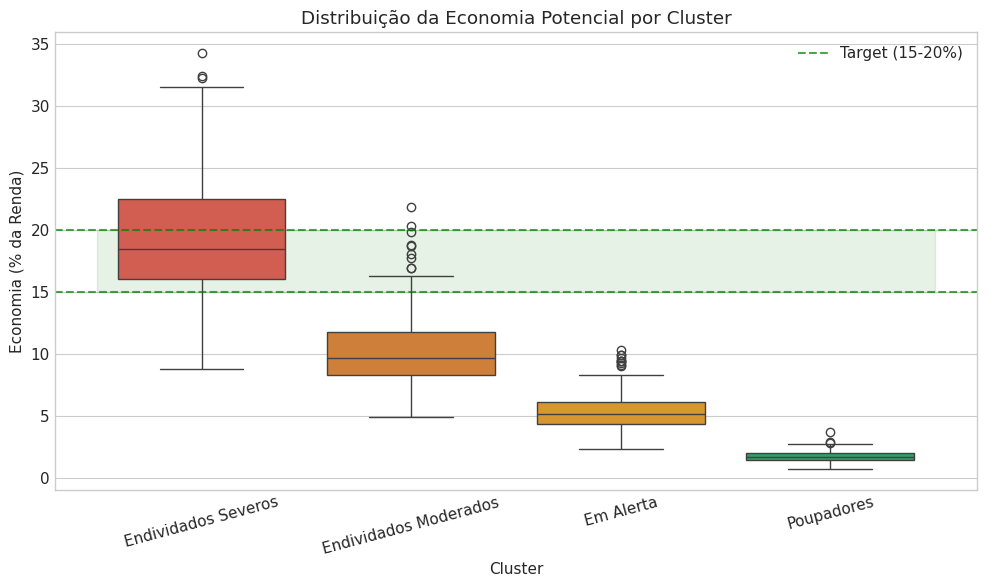

Gráfico salvo: outputs/distribuicao_economia_cluster.png


In [11]:
# Gráfico 2: Distribuição da economia por cluster (boxplot)
fig, ax = plt.subplots(figsize=(10, 6))

economia_df['cluster_nome'] = economia_df['cluster'].map(NOMES_CLUSTERS)

# Ordenar clusters
ordem_clusters = ['Endividados Severos', 'Endividados Moderados', 'Em Alerta', 'Poupadores']

sns.boxplot(
    data=economia_df,
    x='cluster_nome',
    y='pct_economia_renda',
    order=ordem_clusters,
    palette=['#e74c3c', '#e67e22', '#f39c12', '#27ae60']
)

ax.axhline(y=TARGET_MIN, color='green', linestyle='--', alpha=0.7, label=f'Target ({TARGET_MIN}-{TARGET_MAX}%)')
ax.axhline(y=TARGET_MAX, color='green', linestyle='--', alpha=0.7)
ax.fill_between(ax.get_xlim(), TARGET_MIN, TARGET_MAX, alpha=0.1, color='green')

ax.set_xlabel('Cluster')
ax.set_ylabel('Economia (% da Renda)')
ax.set_title('Distribuição da Economia Potencial por Cluster')
ax.legend()

plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('../outputs/distribuicao_economia_cluster.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/distribuicao_economia_cluster.png")

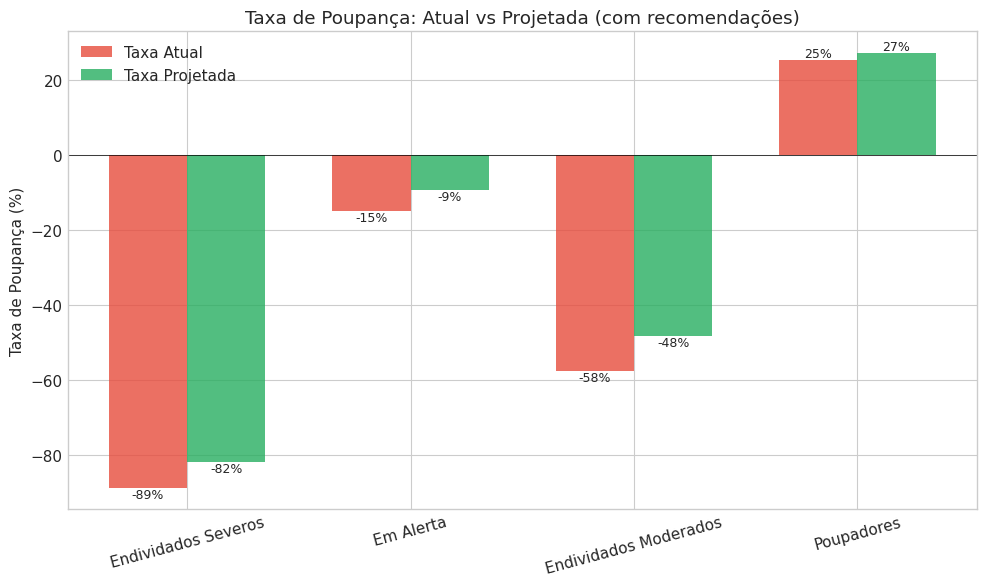

Gráfico salvo: outputs/poupanca_atual_vs_projetada.png


In [12]:
# Gráfico 3: Taxa de poupança atual vs projetada
fig, ax = plt.subplots(figsize=(10, 6))

# Calcular médias por cluster
poupanca_atual = economia_df.groupby('cluster')['taxa_poupanca_atual'].mean() * 100
poupanca_projetada = economia_df.groupby('cluster')['taxa_poupanca_projetada'].mean() * 100

x = np.arange(4)
width = 0.35

bars1 = ax.bar(x - width/2, poupanca_atual.values, width, label='Taxa Atual', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, poupanca_projetada.values, width, label='Taxa Projetada', color='#27ae60', alpha=0.8)

ax.set_ylabel('Taxa de Poupança (%)')
ax.set_title('Taxa de Poupança: Atual vs Projetada (com recomendações)')
ax.set_xticks(x)
ax.set_xticklabels([NOMES_CLUSTERS[i] for i in range(4)], rotation=15)
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Adicionar valores
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f'{height:.0f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f'{height:.0f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/poupanca_atual_vs_projetada.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/poupanca_atual_vs_projetada.png")

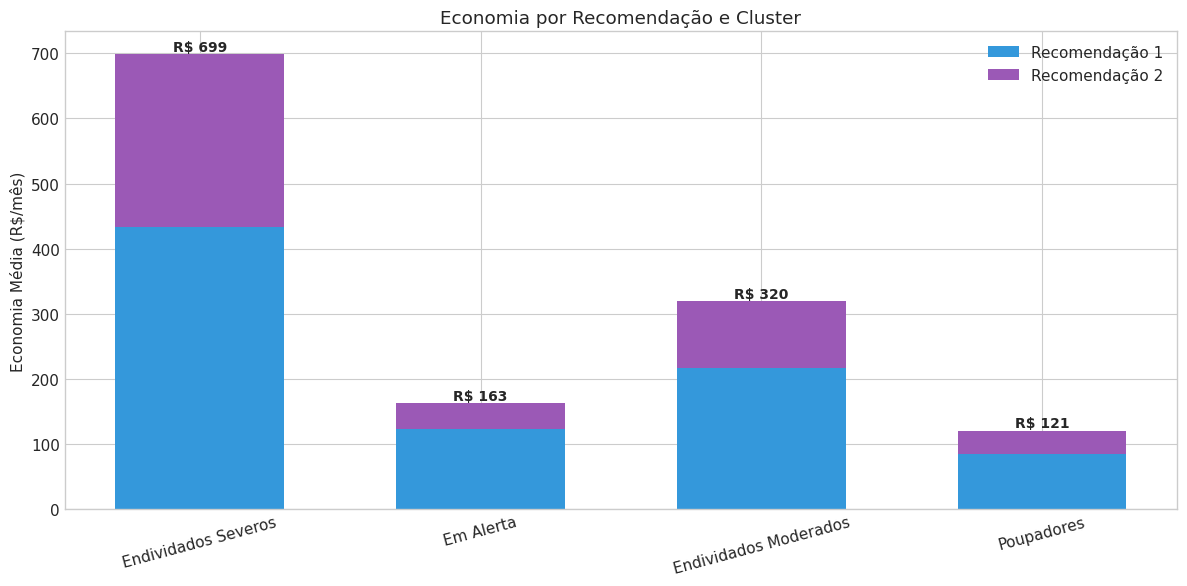

Gráfico salvo: outputs/economia_por_recomendacao.png


In [13]:
# Gráfico 4: Economia por categoria (stacked bar)
fig, ax = plt.subplots(figsize=(12, 6))

# Agregar economia por cluster e categoria
economia_cat1 = economia_df.groupby('cluster')['economia_1'].mean()
economia_cat2 = economia_df.groupby('cluster')['economia_2'].mean()

# Pegar nomes das categorias por cluster
cats_1 = economia_df.groupby('cluster')['categoria_1'].first()
cats_2 = economia_df.groupby('cluster')['categoria_2'].first()

x = np.arange(4)
width = 0.6

bars1 = ax.bar(x, economia_cat1.values, width, label='Recomendação 1', color='#3498db')
bars2 = ax.bar(x, economia_cat2.values, width, bottom=economia_cat1.values, label='Recomendação 2', color='#9b59b6')

ax.set_ylabel('Economia Média (R$/mês)')
ax.set_title('Economia por Recomendação e Cluster')
ax.set_xticks(x)
ax.set_xticklabels([NOMES_CLUSTERS[i] for i in range(4)], rotation=15)
ax.legend()

# Adicionar total no topo
for i, (v1, v2) in enumerate(zip(economia_cat1.values, economia_cat2.values)):
    ax.text(i, v1 + v2 + 5, f'R$ {v1+v2:.0f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/economia_por_recomendacao.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/economia_por_recomendacao.png")

## 6. Salvar Resultados

In [14]:
# Selecionar colunas para o CSV final
colunas_economia = [
    'user_id', 'cluster', 'cluster_nome',
    'media_renda', 'media_gasto',
    'categoria_1', 'gasto_atual_1', 'economia_1', 'recomendacao_1',
    'categoria_2', 'gasto_atual_2', 'economia_2', 'recomendacao_2',
    'economia_total', 'pct_economia_renda', 'pct_economia_gasto',
    'taxa_poupanca_atual', 'taxa_poupanca_projetada', 'melhoria_poupanca'
]

economia_final = economia_df[colunas_economia].copy()

# Salvar CSV
os.makedirs('../data/processed', exist_ok=True)
economia_final.to_csv('../data/processed/economia_projetada.csv', index=False)

print(f"Arquivo salvo: data/processed/economia_projetada.csv")
print(f"Total de linhas: {len(economia_final)}")
print(f"Colunas: {len(economia_final.columns)}")

Arquivo salvo: data/processed/economia_projetada.csv
Total de linhas: 500
Colunas: 19


In [15]:
# Verificar arquivo salvo
economia_verificacao = pd.read_csv('../data/processed/economia_projetada.csv')
print("\nPrimeiras linhas do arquivo salvo:")
economia_verificacao.head()


Primeiras linhas do arquivo salvo:


,user_id,cluster,cluster_nome,media_renda,media_gasto,categoria_1,gasto_atual_1,economia_1,recomendacao_1,categoria_2,gasto_atual_2,economia_2,recomendacao_2,economia_total,pct_economia_renda,pct_economia_gasto,taxa_poupanca_atual,taxa_poupanca_projetada,melhoria_poupanca
0,user_0001,3,Poupadores,11614.322645,3834.969272,Transporte,486.08,72.91,Otimizar gastos com transporte,Telecomunicacoes,103.30,20.66,Revisar planos e assinaturas,93.57,0.805643,2.439915,0.669807,0.677863,0.805643
1,user_0002,0,Endividados Severos,3615.436000,7084.610157,Alimentacao_Fora,737.54,516.28,Cortar refeições fora de casa,Vestuario,362.20,325.98,Suspender compras de vestuário,842.26,23.296222,11.888586,-0.959545,-0.726583,23.296222
2,user_0003,3,Poupadores,6055.769376,3473.659979,Transporte,491.59,73.74,Otimizar gastos com transporte,Telecomunicacoes,102.18,20.44,Revisar planos e assinaturas,94.17,1.555046,2.710973,0.426388,0.441939,1.555046
3,user_0004,1,Em Alerta,2765.230000,3815.743179,Alimentacao_Fora,342.10,136.84,Reduzir refeições fora de casa,Lazer,89.54,31.34,Estabelecer teto para lazer,168.18,6.081953,4.407529,-0.379901,-0.319081,6.081953
4,user_0005,3,Poupadores,6475.678303,6118.832497,Transporte,771.63,115.74,Otimizar gastos com transporte,Telecomunicacoes,149.63,29.93,Revisar planos e assinaturas,145.67,2.249494,2.380683,0.055106,0.077600,2.249494


## 7. Documentação da Validação H1

In [16]:
# Criar relatório de validação H1
relatorio_h1 = f"""
# Validação Hipótese H1
## Recomendações geram economia de 15-20%

**Data:** 2026-01-26
**Sprint:** 2 - Dia 9

---

## Resultado

| Métrica | Target | Resultado | Status |
|---------|--------|-----------|--------|
| Economia média (% renda) | 15-20% | {economia_media_geral:.2f}% | {h1_status} |
| Economia mediana (% renda) | 15-20% | {economia_mediana_geral:.2f}% | - |

---

## Economia por Cluster

| Cluster | Usuários | Economia Média (R$) | Economia Média (% Renda) |
|---------|----------|---------------------|-------------------------|
"""

for cluster_id in range(4):
    cluster_data = economia_df[economia_df['cluster'] == cluster_id]
    relatorio_h1 += f"| {NOMES_CLUSTERS[cluster_id]} | {len(cluster_data)} | R$ {cluster_data['economia_total'].mean():.2f} | {cluster_data['pct_economia_renda'].mean():.2f}% |\n"

relatorio_h1 += f"""
---

## Impacto Total Projetado

- **Economia mensal total (500 usuários):** R$ {economia_df['economia_total'].sum():,.2f}
- **Economia anual total:** R$ {economia_df['economia_total'].sum() * 12:,.2f}
- **Economia média por usuário:** R$ {economia_df['economia_total'].mean():.2f}/mês

---

## Melhoria na Taxa de Poupança

| Cluster | Taxa Atual | Taxa Projetada | Melhoria |
|---------|------------|----------------|----------|
"""

for cluster_id in range(4):
    cluster_data = economia_df[economia_df['cluster'] == cluster_id]
    taxa_atual = cluster_data['taxa_poupanca_atual'].mean() * 100
    taxa_proj = cluster_data['taxa_poupanca_projetada'].mean() * 100
    melhoria = cluster_data['melhoria_poupanca'].mean()
    relatorio_h1 += f"| {NOMES_CLUSTERS[cluster_id]} | {taxa_atual:.1f}% | {taxa_proj:.1f}% | +{melhoria:.1f}pp |\n"

relatorio_h1 += f"""
---

## Conclusão

**Status H1: {h1_status}**

{'As recomendações atingem o target de economia de 15-20% sobre a renda.' if h1_status in ['VALIDADA', 'SUPERADA'] else 'As recomendações não atingem o target mínimo de 15% de economia sobre a renda.'}

---

## Artefatos Gerados

- `data/processed/economia_projetada.csv`
- `outputs/economia_por_cluster.png`
- `outputs/distribuicao_economia_cluster.png`
- `outputs/poupanca_atual_vs_projetada.png`
- `outputs/economia_por_recomendacao.png`
"""

# Salvar relatório
with open('../outputs/validacao_h1.md', 'w', encoding='utf-8') as f:
    f.write(relatorio_h1)

print("Relatório salvo: outputs/validacao_h1.md")
print("\n" + "="*70)
print(relatorio_h1)

Relatório salvo: outputs/validacao_h1.md


# Validação Hipótese H1
## Recomendações geram economia de 15-20%

**Data:** 2026-01-26
**Sprint:** 2 - Dia 9

---

## Resultado

| Métrica | Target | Resultado | Status |
|---------|--------|-----------|--------|
| Economia média (% renda) | 15-20% | 8.11% | NÃO ATINGIDA |
| Economia mediana (% renda) | 15-20% | 6.72% | - |

---

## Economia por Cluster

| Cluster | Usuários | Economia Média (R$) | Economia Média (% Renda) |
|---------|----------|---------------------|-------------------------|
| Endividados Severos | 59 | R$ 698.53 | 19.22% |
| Em Alerta | 196 | R$ 162.59 | 5.37% |
| Endividados Moderados | 167 | R$ 320.13 | 10.38% |
| Poupadores | 78 | R$ 120.90 | 1.72% |

---

## Impacto Total Projetado

- **Economia mensal total (500 usuários):** R$ 135,972.17
- **Economia anual total:** R$ 1,631,666.04
- **Economia média por usuário:** R$ 271.94/mês

---

## Melhoria na Taxa de Poupança

| Cluster | Taxa Atual | Taxa Projetada | Melhoria

## 8. Checklist e Próximos Passos

In [17]:
# Checklist Dia 9
print("\n" + "="*70)
print("CHECKLIST DIA 9")
print("="*70)
print("\n[x] Calcular economia potencial por usuário")
print("[x] Criar DataFrame economia_projetada.csv")
print("[x] Validar H1: % de economia média por cluster")
print("[x] Gerar visualizações de economia por cluster")
print("[x] Documentar resultado da validação H1")
print("[x] Salvar artefatos (CSV, gráficos, relatório)")
print("\n>>> DIA 9 CONCLUÍDO!")
print("\nPróximo passo (Dia 10): Treinar detector de anomalias (Isolation Forest)")


CHECKLIST DIA 9

[x] Calcular economia potencial por usuário
[x] Criar DataFrame economia_projetada.csv
[x] Validar H1: % de economia média por cluster
[x] Gerar visualizações de economia por cluster
[x] Documentar resultado da validação H1
[x] Salvar artefatos (CSV, gráficos, relatório)

>>> DIA 9 CONCLUÍDO!

Próximo passo (Dia 10): Treinar detector de anomalias (Isolation Forest)


In [18]:
# Resumo final
print("\n" + "="*70)
print("RESUMO FINAL - DIA 9")
print("="*70)
print(f"\nHipótese H1: {h1_status}")
print(f"Economia média: {economia_media_geral:.2f}% da renda")
print(f"Target: 15-20%")
print(f"\nArquivos gerados:")
print("  - data/processed/economia_projetada.csv")
print("  - outputs/economia_por_cluster.png")
print("  - outputs/distribuicao_economia_cluster.png")
print("  - outputs/poupanca_atual_vs_projetada.png")
print("  - outputs/economia_por_recomendacao.png")
print("  - outputs/validacao_h1.md")


RESUMO FINAL - DIA 9

Hipótese H1: NÃO ATINGIDA
Economia média: 8.11% da renda
Target: 15-20%

Arquivos gerados:
  - data/processed/economia_projetada.csv
  - outputs/economia_por_cluster.png
  - outputs/distribuicao_economia_cluster.png
  - outputs/poupanca_atual_vs_projetada.png
  - outputs/economia_por_recomendacao.png
  - outputs/validacao_h1.md
